<a href="https://colab.research.google.com/github/AdityaJ9082/ML/blob/main/Tensorflow%20Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Importing Dataset

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [ ]:
list(data_dir.glob('*/*.jpg'))

[PosixPath('/root/.keras/datasets/flower_photos/daisy/1140299375_3aa7024466.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/9515186037_3be48fe68f.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/4746633946_23933c0810.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/7191221492_610035de7c_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/3356112863_75da8bca2c_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/2498632196_e47a472d5a.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/14507818175_05219b051c_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/14333681205_a07c9f1752_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/3703643767_dee82cdef9_n.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/9175280426_40ecc395b8_m.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/5795159787_ebb51a5e75.jpg'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy/2573240560_ff7ffdd4

In [ ]:
len(list(data_dir.glob('*/*.jpg')))#length of the dataset

3670

In [ ]:
roses=list(data_dir.glob('roses*/*'))

In [ ]:
str(roses[0])

'/root/.keras/datasets/flower_photos/roses/16100313047_c2e23cbb3d_n.jpg'

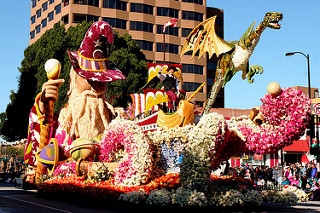

In [ ]:
PIL.Image.open(str(roses[0]))#image

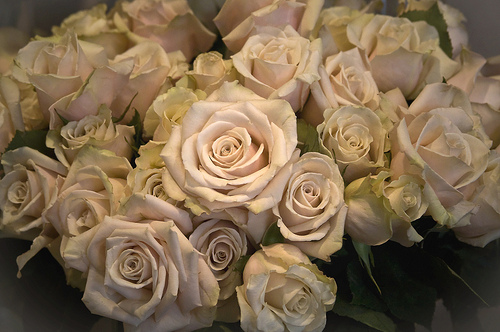

In [ ]:
PIL.Image.open(str(roses[1]))

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(    #data splitting and batching
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class_names=['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']#classes in our dataset

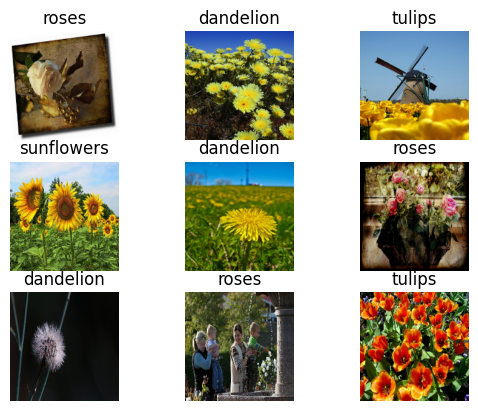

In [ ]:
#visualizing our dataset
for images,labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')



In [ ]:
#configuring
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#standardize our data
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_layer=train_ds.map(lambda x , y :(normalization_layer(x),y))

**Model Building**

In [ ]:
num_classes=len(class_names)
model=tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(128,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(num_classes,activation='softmax')

])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                   

In [ ]:
#Compiling our Model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 18s 146ms/step - loss: 3.1638 - accuracy: 0.3433 - val_loss: 1.4442 - val_accuracy: 0.3488
Epoch 2/10
92/92 [==============================] - 11s 123ms/step - loss: 1.2920 - accuracy: 0.4428 - val_loss: 1.3509 - val_accuracy: 0.4401
Epoch 3/10
92/92 [==============================] - 11s 123ms/step - loss: 1.1305 - accuracy: 0.5477 - val_loss: 1.1739 - val_accuracy: 0.5313
Epoch 4/10
92/92 [==============================] - 12s 126ms/step - loss: 0.9420 - accuracy: 0.6294 - val_loss: 1.1771 - val_accuracy: 0.5232
Epoch 5/10
92/92 [==============================] - 11s 124ms/step - loss: 0.7878 - accuracy: 0.7084 - val_loss: 1.2671 - val_accuracy: 0.5041
Epoch 6/10
92/92 [==============================] - 11s 124ms/step - loss: 0.6683 - accuracy: 0.7476 - val_loss: 1.2830 - val_accuracy: 0.5436
Epoch 7/10
92/92 [==============================] - 11s 124ms/step - loss: 0.5006 - accuracy: 0.8174 - val_loss: 1.3642 - val_accuracy: 0.5450
Epoch 8/10

**Testing**

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

In [ ]:
sunflower_path

'/root/.keras/datasets/Red_sunflower'

In [ ]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

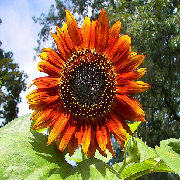

In [ ]:
img

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

1/1 [==============================] - 0s 167ms/step


In [ ]:
img_array.shape

TensorShape([1, 180, 180, 3])

In [ ]:
predictions

array([[3.3870376e-05, 7.7986524e-06, 1.3932659e-02, 9.1426826e-01,
        7.1757458e-02]], dtype=float32)

In [ ]:
score = tf.nn.softmax(predictions)
score

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.15190198, 0.15189803, 0.15402797, 0.37897483, 0.16319716]],
      dtype=float32)>

In [ ]:
np.argmax(score)

3

In [ ]:
class_names[3]

'sunflowers'

In [ ]:
a=model.predict(val_ds)
b=tf.nn.softmax(a)
b=np.argmax(b,axis=-1)

23/23 [==============================] - 0s 16ms/step


In [ ]:
b

array([1, 4, 1, 1, 3, 4, 1, 2, 4, 0, 1, 1, 0, 4, 4, 4, 3, 2, 1, 1, 3, 3,
       4, 1, 1, 1, 1, 1, 3, 4, 2, 3, 3, 0, 4, 1, 1, 1, 1, 4, 4, 3, 3, 2,
       3, 4, 4, 1, 4, 1, 2, 3, 4, 2, 1, 1, 3, 2, 0, 4, 4, 1, 1, 0, 3, 1,
       1, 3, 4, 1, 1, 2, 3, 3, 1, 1, 1, 1, 3, 4, 4, 4, 3, 1, 4, 3, 3, 4,
       3, 0, 1, 1, 1, 2, 4, 4, 2, 2, 4, 1, 2, 4, 1, 4, 2, 1, 1, 3, 3, 2,
       4, 4, 1, 0, 1, 1, 0, 0, 2, 2, 2, 4, 1, 4, 1, 3, 2, 1, 0, 0, 1, 1,
       1, 0, 3, 1, 3, 4, 1, 1, 0, 1, 4, 4, 0, 0, 1, 2, 4, 4, 2, 2, 4, 0,
       4, 1, 3, 2, 4, 3, 3, 4, 4, 1, 1, 4, 3, 3, 2, 0, 1, 2, 3, 0, 4, 3,
       3, 1, 4, 2, 1, 3, 1, 4, 1, 1, 0, 1, 0, 3, 2, 4, 4, 1, 3, 4, 4, 3,
       3, 1, 1, 2, 4, 1, 3, 2, 0, 1, 1, 1, 0, 4, 1, 1, 1, 1, 3, 4, 4, 1,
       2, 4, 1, 4, 0, 1, 3, 1, 0, 1, 3, 4, 3, 1, 4, 3, 4, 4, 1, 2, 3, 3,
       3, 4, 0, 4, 3, 1, 1, 4, 1, 0, 4, 3, 4, 4, 3, 3, 4, 4, 3, 0, 4, 4,
       0, 0, 0, 4, 1, 1, 4, 4, 1, 3, 3, 1, 3, 1, 4, 3, 4, 1, 4, 3, 1, 0,
       4, 1, 1, 4, 4, 1, 4, 2, 3, 2, 1, 0, 1, 0, 1,

In [ ]:
for i in b:
  print(class_names[i])

dandelion
tulips
dandelion
dandelion
sunflowers
tulips
dandelion
roses
tulips
daisy
dandelion
dandelion
daisy
tulips
tulips
tulips
sunflowers
roses
dandelion
dandelion
sunflowers
sunflowers
tulips
dandelion
dandelion
dandelion
dandelion
dandelion
sunflowers
tulips
roses
sunflowers
sunflowers
daisy
tulips
dandelion
dandelion
dandelion
dandelion
tulips
tulips
sunflowers
sunflowers
roses
sunflowers
tulips
tulips
dandelion
tulips
dandelion
roses
sunflowers
tulips
roses
dandelion
dandelion
sunflowers
roses
daisy
tulips
tulips
dandelion
dandelion
daisy
sunflowers
dandelion
dandelion
sunflowers
tulips
dandelion
dandelion
roses
sunflowers
sunflowers
dandelion
dandelion
dandelion
dandelion
sunflowers
tulips
tulips
tulips
sunflowers
dandelion
tulips
sunflowers
sunflowers
tulips
sunflowers
daisy
dandelion
dandelion
dandelion
roses
tulips
tulips
roses
roses
tulips
dandelion
roses
tulips
dandelion
tulips
roses
dandelion
dandelion
sunflowers
sunflowers
roses
tulips
tulips
dandelion
daisy
dandelion
d

In [ ]:
def pred(img):
  a=model.predict(img)
  score = tf.nn.softmax(a)
  a=np.argmax(score,axis=-1)
  # return a
  for i in a:
    print(class_names[i])


In [ ]:
pred(val_ds)

23/23 [==============================] - 0s 17ms/step
dandelion
tulips
dandelion
dandelion
sunflowers
tulips
dandelion
roses
tulips
daisy
dandelion
dandelion
daisy
tulips
tulips
tulips
sunflowers
roses
dandelion
dandelion
sunflowers
sunflowers
tulips
dandelion
dandelion
dandelion
dandelion
dandelion
sunflowers
tulips
roses
sunflowers
sunflowers
daisy
tulips
dandelion
dandelion
dandelion
dandelion
tulips
tulips
sunflowers
sunflowers
roses
sunflowers
tulips
tulips
dandelion
tulips
dandelion
roses
sunflowers
tulips
roses
dandelion
dandelion
sunflowers
roses
daisy
tulips
tulips
dandelion
dandelion
daisy
sunflowers
dandelion
dandelion
sunflowers
tulips
dandelion
dandelion
roses
sunflowers
sunflowers
dandelion
dandelion
dandelion
dandelion
sunflowers
tulips
tulips
tulips
sunflowers
dandelion
tulips
sunflowers
sunflowers
tulips
sunflowers
daisy
dandelion
dandelion
dandelion
roses
tulips
tulips
roses
roses
tulips
dandelion
roses
tulips
dandelion
tulips
roses
dandelion
dandelion
sunflowers
sunf

Saving Our Model

In [ ]:
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 196
drwxr-xr-x 2 root root   4096 Oct 22 06:55 assets
-rw-r--r-- 1 root root     56 Oct 22 07:26 fingerprint.pb
-rw-r--r-- 1 root root  18887 Oct 22 07:26 keras_metadata.pb
-rw-r--r-- 1 root root 163959 Oct 22 07:26 saved_model.pb
drwxr-xr-x 2 root root   4096 Oct 22 07:26 variables


Examinig Our Saved Model

In [ ]:
!saved_model_cli show --dir {export_path} --all

2023-10-22 07:26:11.691449: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['rescaling_1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_rescaling_1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 5)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/se

In [ ]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   7756      0 --:--:-- --:--:-- --:--:--  7744
OK
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu

Installing Tensorflow Server

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2023-10-22 07:26:33--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 2607:f8b0:4023:c06::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 324.39M  52.3MB/s    in 5.8s    

2023-10-22 07:26:38 (55.8 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb’ saved [340152790/340152790]

(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) over (2.8.0) ...
Setting up tensorflow-model-server (2.8.0) ...


In [ ]:
os.environ["MODEL_DIR"] = MODEL_DIR

Serving And Loading Our Model

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8507 \
  --model_name=cnn_models \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Passing Our Test Data

In [ ]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": img_array.numpy().tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))


# {
#   // (Optional) Serving signature to use.
#   // If unspecifed default serving signature is used.
#   "signature_name": <string>,

#   // Input Tensors in row ("instances") or columnar ("inputs") format.
#   // A request can have either of them but NOT both.
#   "instances": <value>|<(nested)list>|<list-of-objects>
#   "inputs": <value>|<(nested)list>|<object>
# }

# {
#   // List of 3 scalar tensors.
#   "instances": [ "foo", "bar", "baz" ]
# }

Data: {"signature_name": "serving_default", "instances": ... 0, 36.0], [41.0, 55.0, 32.0], [42.0, 56.0, 41.0]]]]}


In [ ]:
!pip install -q requests



Getting Our Prdecitions From The Server

In [ ]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8507/v1/models/cnn_models:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

# {
#   "predictions": <value>|<(nested)list>|<list-of-objects>
# }

In [ ]:
predictions

[[3.38703139e-05, 7.79865331e-06, 0.0139326472, 0.914268374, 0.0717574]]

In [ ]:
np.argmax(predictions)

3

In [ ]:
class_names[3]

'sunflowers'

In [ ]:
def pred(predictions):
  pred_class=class_names[np.argmax(predictions)]
  print(pred_class)


In [ ]:
pred(predictions)

sunflowers
